# K Nearest Neigbors = KNN

We store all data points with their assigned classes.

Given a new dta point, its k nearest neighbors are visited; the class of these nearest points accounts for the class of the new point. I imgine some kind of weighted voting could be used, depending on the implementation.

In order to get the k nearest points, we need to compute the distances from the new data point to the dataset points -- if all points are considered, that's very expensive, but if we use some kind of tree structure (kd tree, octree), that process could be accelerated.

k and the density of the class samples affects the outcome:
- small k: noise
- bigger k: smoother, but higher bias

Pros:
- Very simple
- It works with any number of classes
- Easy to extend (add more data)
- Few params: k, distance metric

Cons:
- High prediction cost, worst for large dataset
- Not good with high dimensional data
- Categorical features don't work well

**Important note: In kNN, the scale of the variables is important**, because we compute distances! Therefore, we need to normalize them (`StandardScaler` scales and centers data -- center? really?!)

#### Classified Dataset

We get a take-home assignment in an interview in which we need to apply kNN with unknown data columns.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
df = pd.read_csv('data/Classified Data')

In [4]:
# Anonymized column names
df.head()

,Unnamed: 0,WTT,PTI,EQW,SBI,LQE,QWG,FDJ,PJF,HQE,NXJ,TARGET CLASS
0,0,0.913917,1.162073,0.567946,0.755464,0.780862,0.352608,0.759697,0.643798,0.879422,1.231409,1
1,1,0.635632,1.003722,0.535342,0.825645,0.924109,0.648450,0.675334,1.013546,0.621552,1.492702,0
2,2,0.721360,1.201493,0.921990,0.855595,1.526629,0.720781,1.626351,1.154483,0.957877,1.285597,0
3,3,1.234204,1.386726,0.653046,0.825624,1.142504,0.875128,1.409708,1.380003,1.522692,1.153093,1
4,4,1.279491,0.949750,0.627280,0.668976,1.232537,0.703727,1.115596,0.646691,1.463812,1.419167,1


In [5]:
df.describe()

,Unnamed: 0,WTT,PTI,EQW,SBI,LQE,QWG,FDJ,PJF,HQE,NXJ,TARGET CLASS
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,499.500000,0.949682,1.114303,0.834127,0.682099,1.032336,0.943534,0.963422,1.071960,1.158251,1.362725,0.50000
std,288.819436,0.289635,0.257085,0.291554,0.229645,0.243413,0.256121,0.255118,0.288982,0.293738,0.204225,0.50025
min,0.000000,0.174412,0.441398,0.170924,0.045027,0.315307,0.262389,0.295228,0.299476,0.365157,0.639693,0.00000
25%,249.750000,0.742358,0.942071,0.615451,0.515010,0.870855,0.761064,0.784407,0.866306,0.934340,1.222623,0.00000
50%,499.500000,0.940475,1.118486,0.813264,0.676835,1.035824,0.941502,0.945333,1.065500,1.165556,1.375368,0.50000
75%,749.250000,1.163295,1.307904,1.028340,0.834317,1.198270,1.123060,1.134852,1.283156,1.383173,1.504832,1.00000
max,999.000000,1.721779,1.833757,1.722725,1.634884,1.650050,1.666902,1.713342,1.785420,1.885690,1.893950,1.00000


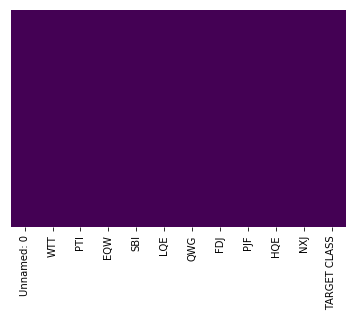

In [8]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [9]:
df.columns

Index(['Unnamed: 0', 'WTT', 'PTI', 'EQW', 'SBI', 'LQE', 'QWG', 'FDJ', 'PJF',
       'HQE', 'NXJ', 'TARGET CLASS'],
      dtype='object')

In [10]:
X = df[['WTT', 'PTI', 'EQW', 'SBI', 'LQE', 'QWG', 'FDJ', 'PJF', 'HQE', 'NXJ']]
y = df['TARGET CLASS']
# We could do also:
# X = df[df.columns[1:-1]]

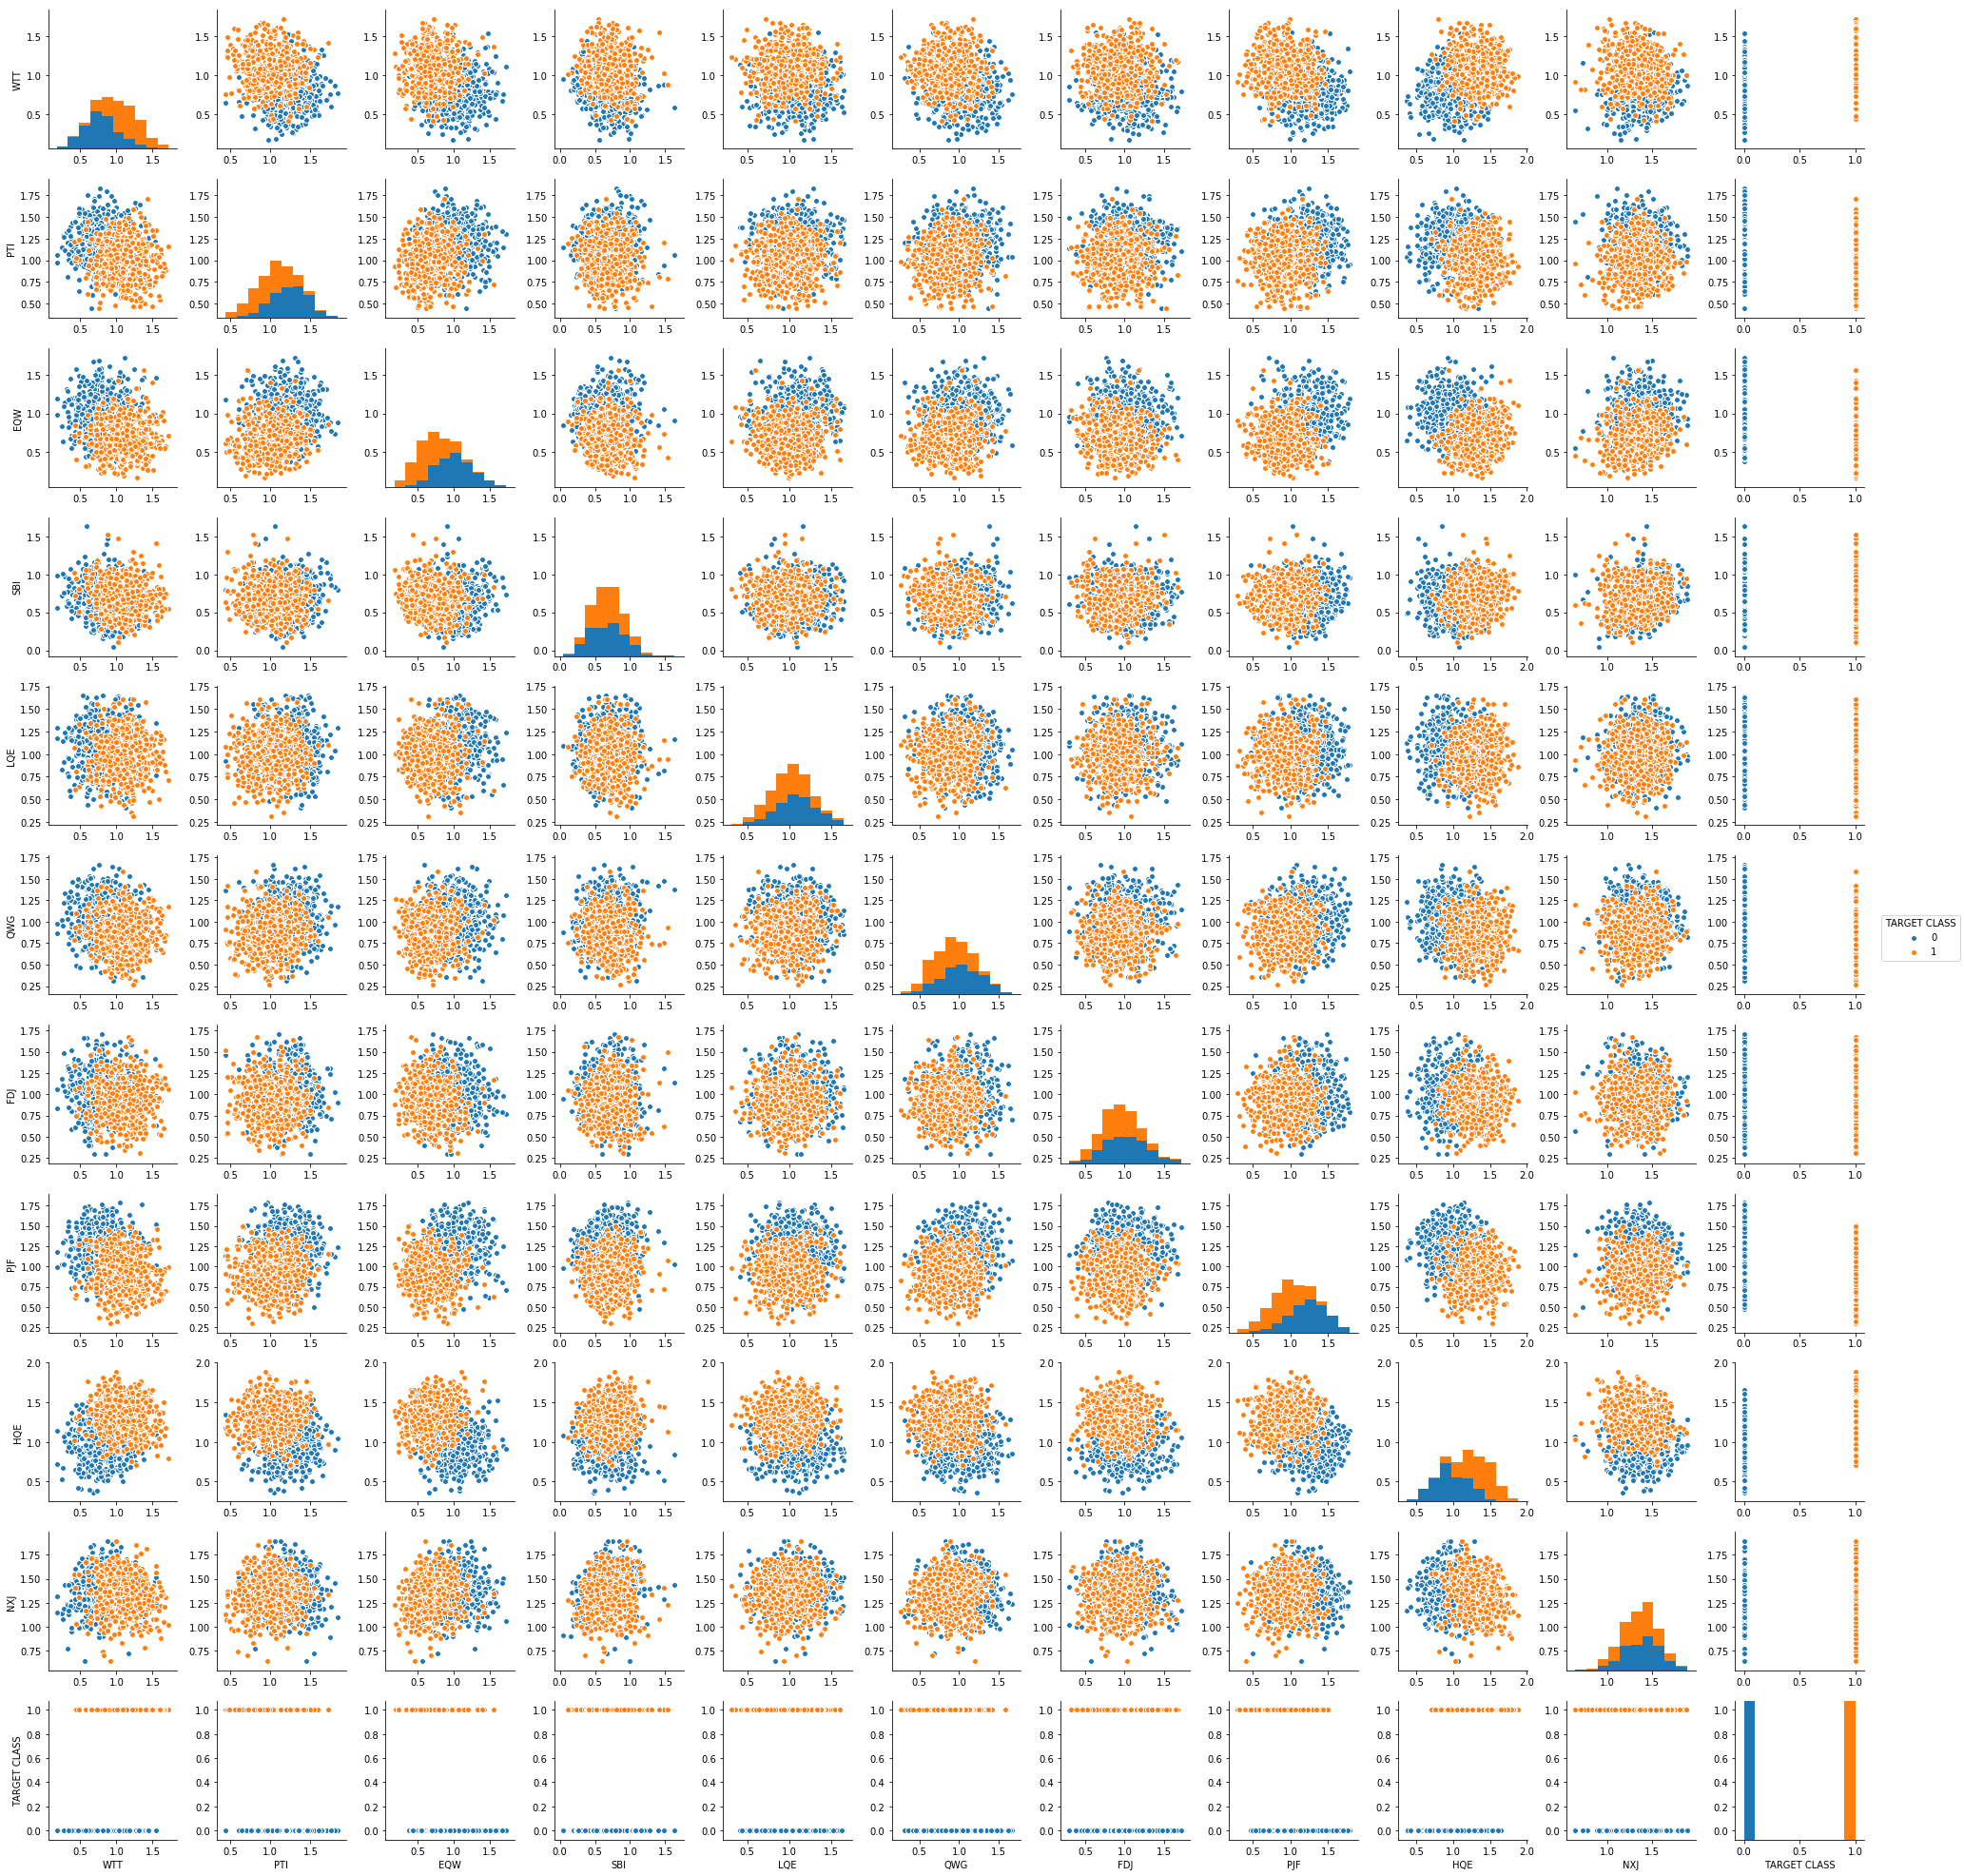

In [42]:
# Always visualize dataset
# Remove unnecessary cols and use hue for classes
cols = df.columns
sns.pairplot(data=df[cols[1:]],hue='TARGET CLASS')

In [12]:
# In kNN, the scale of the variables is important, because we compute distances!
# Therefore, we need to normalize them
from sklearn.preprocessing import StandardScaler

In [13]:
# Instantiate scaler
scaler = StandardScaler()

In [15]:
# Fit scaler to data
scaler.fit(X)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [20]:
# Transform data: scale & center (center? really?!)
# Note it returns an array -> we need to convert it to dataframe
scaled_features = scaler.transform(X)

In [21]:
scaled_features.shape

(1000, 10)

In [23]:
scaled_features[:3]

array([[-0.12354188,  0.18590747, -0.91343069,  0.31962911, -1.03363681,
        -2.3083747 , -0.79895135, -1.48236813, -0.9497194 , -0.64331425],
       [-1.08483602, -0.43034845, -1.02531333,  0.62538826, -0.44484713,
        -1.15270604, -1.12979749, -0.20224031, -1.82805088,  0.63675862],
       [-0.78870217,  0.33931821,  0.30151137,  0.75587279,  2.03169299,
        -0.87015616,  2.59981844,  0.28570652, -0.68249379, -0.37784986]])

In [25]:
# Convert scaled features to data frame
X = pd.DataFrame(scaled_features,columns=['WTT', 'PTI', 'EQW', 'SBI', 'LQE', 'QWG', 'FDJ', 'PJF', 'HQE', 'NXJ'])

In [26]:
X.head()

,WTT,PTI,EQW,SBI,LQE,QWG,FDJ,PJF,HQE,NXJ
0,-0.123542,0.185907,-0.913431,0.319629,-1.033637,-2.308375,-0.798951,-1.482368,-0.949719,-0.643314
1,-1.084836,-0.430348,-1.025313,0.625388,-0.444847,-1.152706,-1.129797,-0.202240,-1.828051,0.636759
2,-0.788702,0.339318,0.301511,0.755873,2.031693,-0.870156,2.599818,0.285707,-0.682494,-0.377850
3,0.982841,1.060193,-0.621399,0.625299,0.452820,-0.267220,1.750208,1.066491,1.241325,-1.026987
4,1.139275,-0.640392,-0.709819,-0.057175,0.822886,-0.936773,0.596782,-1.472352,1.040772,0.276510


In [29]:
# Train-test split
from sklearn.model_selection import train_test_split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [32]:
# We load the kNN classifier
from sklearn.neighbors import KNeighborsClassifier

In [33]:
# We instantiate the classifier
# We need to choose a k = n_neighbors value
# We start with k = 1 and then use the elbow method to select the best k value
knn = KNeighborsClassifier(n_neighbors=1)

In [34]:
# Train/Fit
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [35]:
# Predict/Infer
pred = knn.predict(X_test)

In [36]:
pred

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       0])

In [37]:
from sklearn.metrics import classification_report, confusion_matrix

In [38]:
# It seems to work nicely
print(confusion_matrix(y_test,pred))

[[151   8]
 [ 15 126]]


In [40]:
# It seems to work nicely
print(classification_report(y_test,pred))

             precision    recall  f1-score   support

          0       0.91      0.95      0.93       159
          1       0.94      0.89      0.92       141

avg / total       0.92      0.92      0.92       300



**Elbow Method: How to improve results chainging k**

This consists basically in iterating many models with different k values and seeing how the error changes.

In [43]:
error_rate = []

for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

In [44]:
plt.figure(figsize=(10,6))

Text(0,0.5,'Error rate')

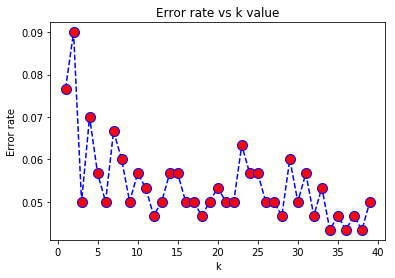

In [50]:
plt.plot(range(1,40),error_rate,
         color='blue',
         linestyle='dashed',
         marker='o',
         markerfacecolor='red',
         markersize=10)
plt.title('Error rate vs k value')
plt.xlabel('k')
plt.ylabel('Error rate')

We see that the error rate becomes smaller as k increases, although it is bumpy -- that's probably because the rror is already small. From visual observation, we take k = 17.

In [54]:
# We select the optimim k and fit the model one last time
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)
print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test,pred))

[[153   6]
 [  9 132]]


             precision    recall  f1-score   support

          0       0.94      0.96      0.95       159
          1       0.96      0.94      0.95       141

avg / total       0.95      0.95      0.95       300

